Homework #6

Problem 1

In [1]:
import idx2numpy
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
Adata = idx2numpy.convert_from_file("train-images-idx3-ubyte")

(60000, 28, 28)


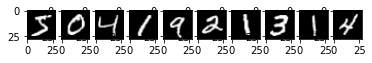

In [3]:
print(Adata.shape)
fig,axs = plt.subplots(1,10)
for i in range(10):
    axs[i].imshow(Image.fromarray(Adata[i,:,:]),cmap="gray")

In [4]:
Bdata = idx2numpy.convert_from_file("train-labels-idx1-ubyte")

In [5]:
print(Bdata.shape)
print(Bdata[0:10])

(60000,)
[5 0 4 1 9 2 1 3 1 4]


In [6]:
A = Adata.reshape((60000,28*28))
B = np.zeros((60000,10))
for i in range(60000):
    B[i,(9+Bdata[i])%10] = 1
B[0:10,:]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [7]:
from scipy import linalg
from sklearn import linear_model as lm,preprocessing as pp,multiclass as mc
from matplotlib import pyplot as plt

First, we will solve using three different algorithms, just to get some basic ideas for the mapping $X$.

In [8]:
%time X = lm.LinearRegression().fit(A,B)

CPU times: user 10.9 s, sys: 587 ms, total: 11.5 s
Wall time: 2.55 s


In [9]:
%time X1 = lm.Lasso(alpha=1).fit(A,B)

CPU times: user 1min 16s, sys: 9.38 s, total: 1min 26s
Wall time: 15.1 s


In [10]:
%time X2 = lm.Ridge(alpha=1).fit(A,B)

CPU times: user 2.69 s, sys: 262 ms, total: 2.95 s
Wall time: 583 ms


In [11]:
%time X3 = lm.ElasticNet(alpha=1,l1_ratio=0.5).fit(A,B)

CPU times: user 1min 32s, sys: 12.3 s, total: 1min 45s
Wall time: 18.4 s


In [12]:
print(X.coef_.shape)

(10, 784)


In [13]:
print(np.sum(1-np.isclose(X.coef_,0)))
print(np.sum(1-np.isclose(X1.coef_,0)))
print(np.sum(1-np.isclose(X2.coef_,0)))
print(np.sum(1-np.isclose(X3.coef_,0)))

7696
833
7168
1203


In [14]:
Xma = np.ma.masked_values(X.coef_.flatten(),0)
X1ma = np.ma.masked_values(X1.coef_.flatten(),0)
X2ma = np.ma.masked_values(X2.coef_.flatten(),0)
X3ma = np.ma.masked_values(X3.coef_.flatten(),0)

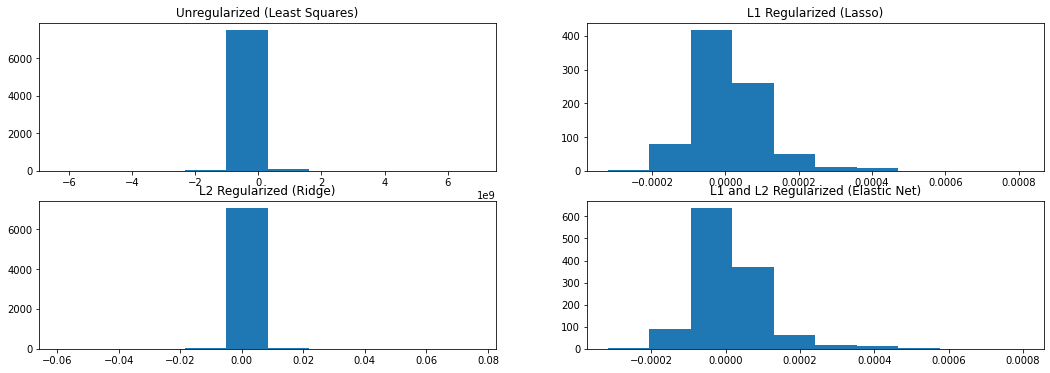

In [15]:
fig,axs = plt.subplots(2,2,figsize=(18,6))
axs[0,0].hist(np.ma.masked_values(X.coef_.flatten(),0).compressed())
axs[0,0].set_title("Unregularized (Least Squares)")
axs[0,1].hist(np.ma.masked_values(X1.coef_.flatten(),0).compressed())
axs[0,1].set_title("L1 Regularized (Lasso)")
axs[1,0].hist(np.ma.masked_values(X2.coef_.flatten(),0).compressed())
axs[1,0].set_title("L2 Regularized (Ridge)")
axs[1,1].hist(np.ma.masked_values(X3.coef_.flatten(),0).compressed())
axs[1,1].set_title("L1 and L2 Regularized (Elastic Net)")
plt.show()

We can see that very clearly, the unregularized problem is unstable, producing wildly erratic results. The Elastic Net and Lasso seem to be performing roughly equivalently, however, Lasso is perhaps slightly faster. So we will use the Lasso to determine our most important pixels. 

Problem 2

We will determine which pixels are most important by assessing which pixels remain non-zero as we ramp up the regularization parameter. We will rank them by the order in which they drop out, and the magnitude of the coefficient in the step before they drop out.

In [16]:
Xalpha = [lm.LinearRegression().fit(A,B)]
for i in [0.01,0.1]+list(range(1,15)):
    Xalpha += [lm.Lasso(alpha=i).fit(A,B)]

In [17]:
sumXbyPixel = [np.ones(10) @ np.abs(X.coef_) for X in Xalpha]

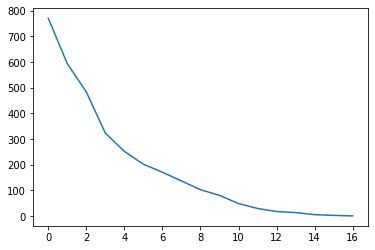

In [18]:
plt.plot([np.sum(1-np.isclose(X,0)) for X in sumXbyPixel])
plt.show()

In [19]:
impPixels = []
for s in sumXbyPixel:
    imp = np.reshape(np.copy(s),(28,28))
    imp -= np.min(imp)
    imp *= 127/np.max(imp)
    impPixels += [imp.astype("uint8")]

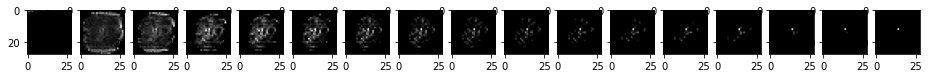

In [20]:
fig,axs = plt.subplots(1,17,figsize=(16,1))
for i in range(17):
    axs[i].imshow(Image.fromarray(impPixels[i]),cmap="gray")

Here we can see that there are a cloud of important pixels around the center where most of the digits lie. It stands to reason that almost all of the pixels around the border are usually black and uninformative. However, at small amounts of regularization we can see that these uninformative pixels are the most prominent. Probably, this is because only a very small number of digits reach these pixels and so the model can ensure that those digits are correctly labeled by swamping the information from almost every other pixels.

In [21]:
pixels_order = []
for i in range(17,0,-1):
    which_nz, = np.nonzero(sumXbyPixel[i-1])
    which_new_nz = [j for j in which_nz if j not in pixels_order]
    new_nzs = [sumXbyPixel[i-1][j] for j in which_new_nz]
    order = np.flip(np.argsort(np.abs(new_nzs)))
    which_nzs_in_order = [which_new_nz[j] for j in order]
    pixels_order += which_nzs_in_order

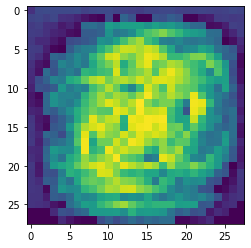

In [22]:
pixels_importance_img = np.zeros(28*28)
for i in range(len(pixels_order)):
    pixels_importance_img[pixels_order[i]] = (len(pixels_order)-i)*127/len(pixels_order)
pixels_importance_img = np.reshape(pixels_importance_img,(28,28))
plt.imshow(Image.fromarray(pixels_importance_img.astype("uint8")))
plt.show()

Problem 3

Here we are using a sort of hybrid approach. We use LASSO to determine the importance of a pixel, and therefore to determine a series of sparsity patterns. However, then for simplicity, speed, and to ensure every pixel is actually used, we will just use least squares regression to actually model the response for a given sparsity pattern.

In [23]:
testAdata = idx2numpy.convert_from_file("t10k-images-idx3-ubyte")
testBdata = idx2numpy.convert_from_file("t10k-labels-idx1-ubyte")
testA = testAdata.reshape((10000,28*28))
testB = np.zeros((10000,10))
for i in range(10000):
    testB[i,(9+testBdata[i])%10] = 1

In [24]:
MSEs = []
num_corrects = []
for i in range(1,784,5):
    included_px = pixels_order[0:i]
    smallA = A[:,included_px]
    regr = lm.LinearRegression()
    smallAinvB = regr.fit(smallA,B)
    
    smalltestA = testA[:,included_px]
    raw_pred = regr.predict(smalltestA)
    dig_pred = (np.argmax(raw_pred,axis=1) + 1) % 10
    
    MSEs += [np.mean((raw_pred-testB)**2)]
    num_corrects += [np.sum(np.equal(dig_pred,testBdata))]

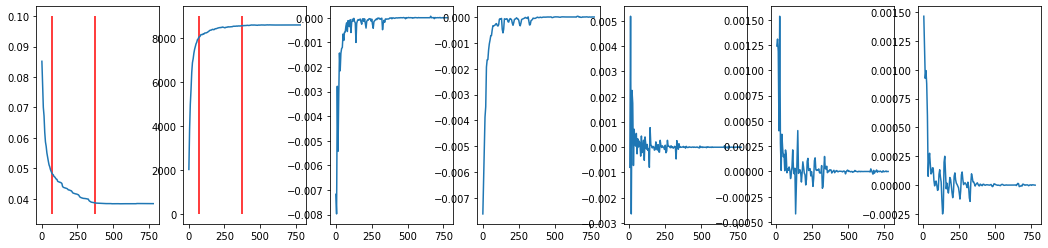

In [25]:
MSEs = np.array(MSEs)
num_corrects = np.array(num_corrects)

fig,axs = plt.subplots(1,7,figsize=(18,4))
axs[0].plot(range(1,784,5),MSEs)
axs[0].vlines([75,375],0.035,0.1,color="r")
axs[1].plot(range(1,784,5),num_corrects)
axs[1].vlines([75,375],0,9000,color="r")

from scipy.signal import savgol_filter

MSEs_smooth = savgol_filter(MSEs,5,2)
MSEd1 = MSEs[1:] - MSEs[:-1]
MSE_smoothd1 = MSEs_smooth[1:] - MSEs_smooth[:-1]
MSE_smoothd1_smooth = savgol_filter(MSE_smoothd1,5,2)
MSEd2 = MSEs[2:] - 2*MSEs[1:-1] + MSEs[:-2]
MSE_smoothd2 = MSEs_smooth[2:] - 2*MSEs_smooth[1:-1] + MSEs_smooth[:-2]
MSE_smoothsmoothd2 = MSE_smoothd1_smooth[1:] - MSE_smoothd1_smooth[:-1]
axs[2].plot(range(1,779,5),MSEd1)
axs[3].plot(range(1,779,5),MSE_smoothd1)
axs[4].plot(range(6,779,5),MSEd2)
axs[5].plot(range(6,779,5),MSE_smoothd2)
axs[6].plot(range(6,779,5),MSE_smoothsmoothd2)

Although we would like to automate the selection of the elbow point, the numerical second derivative (the maximum of which gives the elbow point) is too noisy. 

However, we can see that although the basic linear regression vastly overfits the coefficients, the predictions are fairly reasonable. This makes sense, because we gave it an extraordinary amount of data for a relatively simple problem. Thus, increasing the number of pixels does continue to improve the MSE, as well as the number correctly identified (using the maximum prediction as the predicted digit). However, the "elbows" of the curves occur at about 75 digits (for greatest efficiency) and 375 digits (for greatest effectiveness while removing the truly useless pixels).

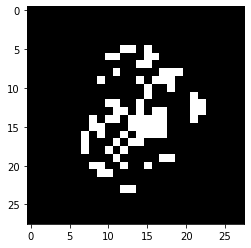

In [26]:
pixels_included_img = np.zeros(28*28)
for i in range(75):
    pixels_included_img[pixels_order[i]] = 127
pixels_included_img = np.reshape(pixels_included_img,(28,28))
plt.imshow(Image.fromarray(pixels_included_img.astype("uint8")),cmap="gray")
plt.show()

Problem 4

First we will write a function to automate this process.

In [27]:
def order_pixels(A,B,lasso_pars):
    Xs = [lm.LinearRegression().fit(A,B)]
    for p in lasso_pars:
        Xs += [lm.Lasso(alpha=p).fit(A,B)]
        
    abs_coefs = [np.abs(X.coef_).flatten() for X in Xs]
    
    pixels_order = []
    for i in range(len(Xs),0,-1):
        which_nz, = np.nonzero(abs_coefs[i-1])
        which_new_nz = [j for j in which_nz if j not in pixels_order]
        new_nzs = [abs_coefs[i-1][j] for j in which_new_nz]
        order = np.flip(np.argsort(np.abs(new_nzs)))
        which_nzs_in_order = [which_new_nz[j] for j in order]
        pixels_order += which_nzs_in_order
        
    return pixels_order

def make_importance_img(pixels_order,axs=plt):
    pixels_importance_img = np.zeros(28*28)
    for i in range(len(pixels_order)):
        pixels_importance_img[pixels_order[i]] = (len(pixels_order)-i)*127/len(pixels_order)
    pixels_importance_img = np.reshape(pixels_importance_img,(28,28))
    axs.imshow(Image.fromarray(pixels_importance_img.astype("uint8")),cmap="gray")
    
def make_included_img(pixels_order,num,axs=plt):
    pixels_included_img = np.zeros(28*28)
    for i in range(num):
        pixels_included_img[pixels_order[i]] = 127
    pixels_included_img = np.reshape(pixels_included_img,(28,28))
    axs.imshow(Image.fromarray(pixels_included_img.astype("uint8")),cmap="gray")
    
def eval_num_pixels(A,B,testA,testB,pixels_order,num_px):
    
    MSEs = []
    for i in num_px:
        included_px = pixels_order[0:i]
        smallA = A[:,included_px]
        regr = lm.LinearRegression()
        smallAinvB = regr.fit(smallA,B)

        smalltestA = testA[:,included_px]
        raw_pred = regr.predict(smalltestA)

        MSEs += [np.mean((raw_pred-testB)**2)]
        
    return MSEs

magic_number = 50
def make_digit_plot(order,MSEs,num_px,axs):
    make_importance_img(order,axs[0])
    axs[1].plot(num_px,MSEs)
    axs[1].vlines([magic_number],0.01,0.1,color="r")
    make_included_img(order,magic_number,axs[2])
    
def make_digit_plots(orders,MSEs,num_pxs):
    fig,axs = plt.subplots(len(orders),3,figsize=(8,30))
    for i in range(len(orders)):
        make_digit_plot(orders[i],MSEs[i],num_pxs,axs[i])
    plt.show()

In [28]:
orders = [order_pixels(A,B[:,i],[0.01,0.1,1,3,5,10]) for i in range(10)]

In [29]:
num_pxs = range(1,784,10)
MSEs = [eval_num_pixels(A,B[:,i],testA,testB[:,i],orders[i],num_pxs) for i in range(10)]

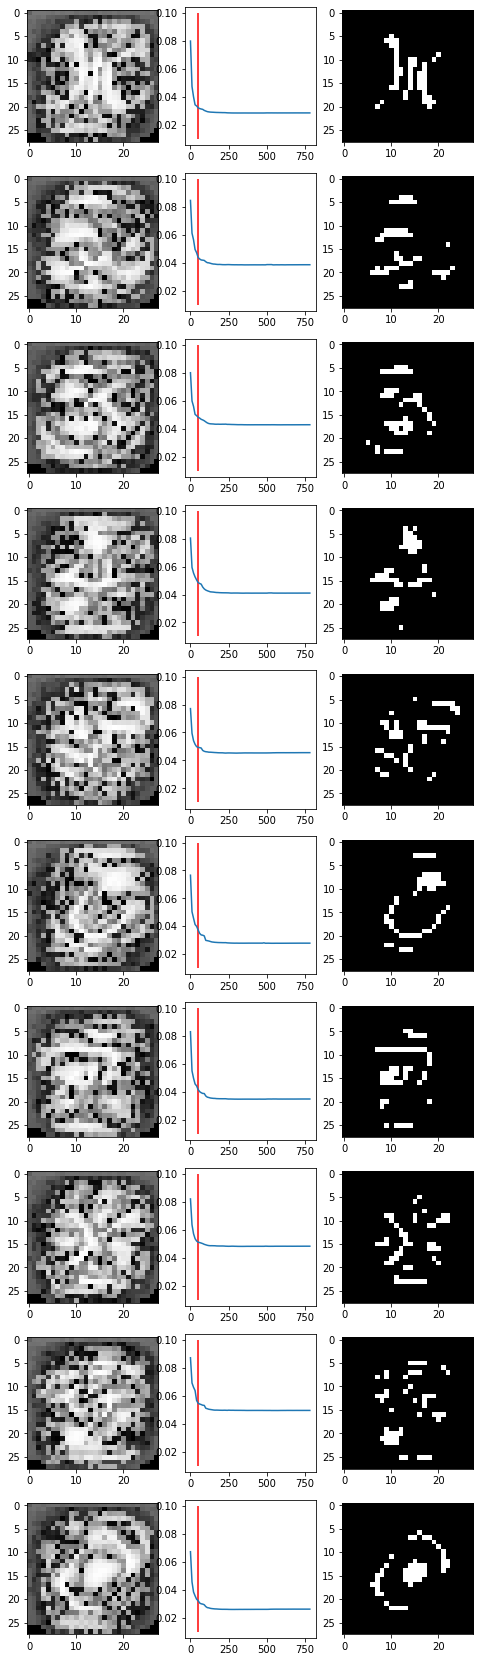

In [30]:
make_digit_plots(orders,MSEs,num_pxs)

Here we can see that we need only about 50 pixels to represent each digit, and fewer for certain digits. However, these pixels are quite different depending on the particular digit. The pixels included vaguely resemble the outline of each individual digit, although only vaguely. However, it is difficult to use this as a classifier. We might heuristically propose to use the argmaximum predicted value as the classified digit. When we do so we see that we obtain $\approx 83\%$ accuracy with $< 7\%$ of the data.

In [31]:
def num_c(i):
    fits = [lm.LinearRegression().fit(A[:,orders[j][0:i]],B[:,j]) for j in range(10)]
    preds = [fits[j].predict(testA[:,orders[j][0:i]]) for j in range(10)]
    raw_preds = np.array(preds)
    dig_preds = (np.argmax(raw_preds,axis=0) + 1) % 10
    return np.sum(np.equal(dig_preds,testBdata))

num_corrects = [num_c(i) for i in range(1,784,50)]

8319


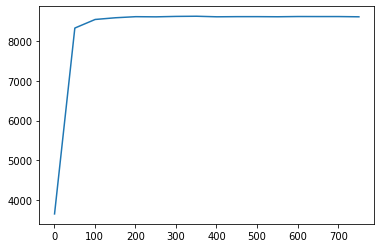

In [32]:
print(num_corrects[1])
plt.plot(range(1,784,50),num_corrects)
plt.show()

Problem 5

By solving $AX=B$ in this way what we're really doing is minimizing $B-AX$, or to cast this as a classic regression problem, we're minimizing $Y-X\beta$ where $Y$ are our labels and $X$ are our pixels. More traditionally, this would be solved as a logistic regression problem since each predictor $\hat{Y}$ can then be interpreted as a probability of having a certain digit identity. This interpretation gets slightly messier with multiple digits, however the use as a classifier is much more effective. We will now measure the performance of logistic regression relative to linear regression.

Since logistic regression is substantially less computationally efficient than linear regression, particularly with $\ell_1$ penalties, we will reuse the 50 pixels selected in Problem 4 for each digit.

In [43]:
scaler = pp.StandardScaler().fit(A)
scaledA = scaler.transform(A)

logist_fits = [lm.LogisticRegression().fit(scaledA[:,orders[i][0:magic_number]],B[:,i]) for i in range(10)]

In [44]:
scaled_testA = scaler.transform(testA)
preds = [logist_fits[i].predict(scaled_testA[:,orders[i][0:magic_number]]) for i in range(10)]

In [47]:
raw_preds = np.array(preds)
dig_preds = (np.argmax(raw_preds,axis=0) + 1) % 10
num_correct = np.sum(np.equal(dig_preds,testBdata))
print(num_correct)

7857


In [48]:
regr = lm.LogisticRegression(max_iter=200)
regr.fit(scaledA[:,orders[0][:100]],B[:,0])
regr.score(scaled_testA[:,orders[0][:100]],testB[:,0])

0.9905

One way to move from a logistic regression classifier for a single digit to many digits is to use a One-vs-Rest Classifier, which is consistent with our definition of $B$. 

In [49]:
clsf = mc.OneVsRestClassifier(lm.LogisticRegression(max_iter=1000))
clsf.fit(scaledA[:,pixels_order[0:175]],B)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [50]:
preds = clsf.predict(scaled_testA[:,pixels_order[0:175]])
dig_preds = (np.argmax(preds,axis=1) + 1) % 10
np.sum(np.equal(dig_preds,testBdata))

8260

In [51]:
def num_c(i):
    logist_fits = [lm.LogisticRegression(max_iter=1000).fit(scaledA[:,orders[j][0:i]],B[:,j]) for j in range(10)]
    preds = [logist_fits[j].predict(scaled_testA[:,orders[j][0:i]]) for j in range(10)]
    raw_preds = np.array(preds)
    dig_preds = (np.argmax(raw_preds,axis=0) + 1) % 10
    return np.sum(np.equal(dig_preds,testBdata))

num_corrects = [num_c(i) for i in range(1,384,50)]

7901


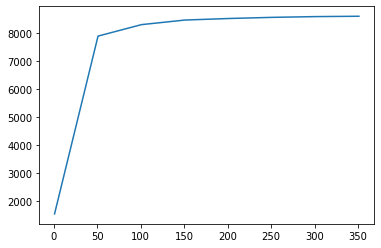

In [52]:
print(num_corrects[1])
plt.plot(range(1,384,50),num_corrects)
plt.show()

This approach does not achieve as good classification, achieving only about $79\%$ accuracy with 50 pixels, but the classification is more interpretable. Furthermore, slow iterations may have impacted the quality of the final models.

Finally, we note that the data itself is probably extremely low-rank, since each digit probably has a rank of $O(1)$. So let us try a low-rank SVD of $A$ to obtain estimates.

In [53]:
U,S,Vh = linalg.svd(A,full_matrices=False)

In [54]:
print(U.shape)
print(Vh.shape)

(60000, 784)
(784, 784)


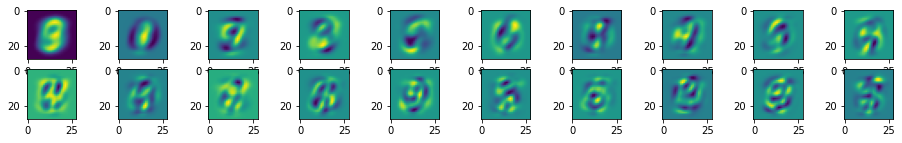

In [55]:
fig,axs = plt.subplots(2,10,figsize=(16,2))
def imgify(v):
    v -= np.min(v)
    v *= 127/np.max(v)
    return np.reshape(v,(28,28)).astype("uint8")

for i in range(10):
    axs[0][i].imshow(Image.fromarray(imgify(Vh[i,:])))
for i in range(10):
    axs[1][i].imshow(Image.fromarray(imgify(Vh[10+i,:])))
plt.show()

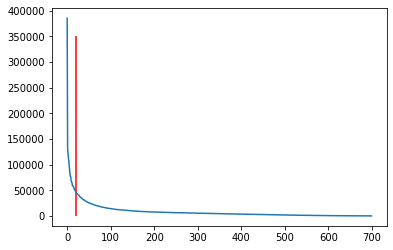

In [56]:
plt.plot(S[0:700])
plt.vlines([20],0,350000,color="r")
plt.show()

In [57]:
U_appr,S_appr,Vh_appr = U[:,:50],S[:50],Vh[:50,:]
A_appr = scaler.inverse_transform(U_appr @ np.diag(S_appr) @ Vh_appr)

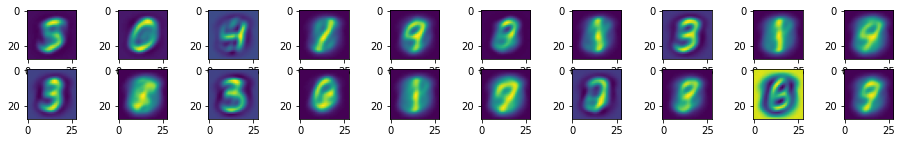

In [58]:
fig,axs = plt.subplots(2,10,figsize=(16,2))

for i in range(10):
    axs[0][i].imshow(Image.fromarray(imgify(A_appr[i,:])))
for i in range(10):
    axs[1][i].imshow(Image.fromarray(imgify(A_appr[10+i,:])))
plt.show()

We do obtain at least decent reconstructions, however despite the apparent simplicity of the procedure I have been unable to get good estimates from low-rank approximation regression.